In [1]:
import os

# this stops jax from stealing all the memory
os.environ["XLA_PYTHON_CLIENT_PREALLOCATE"]="false"

import jax
jax.config.update("jax_default_device", jax.devices("cpu")[0])

import seaborn as sns
import matplotlib.pyplot as plt
import jax.numpy as jnp
from orbax.checkpoint import (CheckpointManager,
                              PyTreeCheckpointer)

from projectlib.data import load_dataset

sns.set_theme(context="paper",
              font_scale=1.25,
              style="ticks",
              palette="colorblind")

2024-01-19 19:07:24.383863: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


# Reservoir results

In [84]:
# ckpt_path = "outputs/train-reservoir/2024-01-18/21-56-07/checkpoints/"
ckpt_path = "outputs/train-reservoir/2024-01-18/22-42-35/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
ckpt = mgr.restore(mgr.latest_step())

In [85]:
targets = jnp.concatenate([jnp.reshape(x, (-1, x.shape[-1]))
                           for x in ckpt["metrics_history"]["train"]["target"]], axis=0)
outputs = jnp.concatenate([jnp.reshape(x, (-1, x.shape[-1]))
                           for x in ckpt["metrics_history"]["train"]["output"]], axis=0)

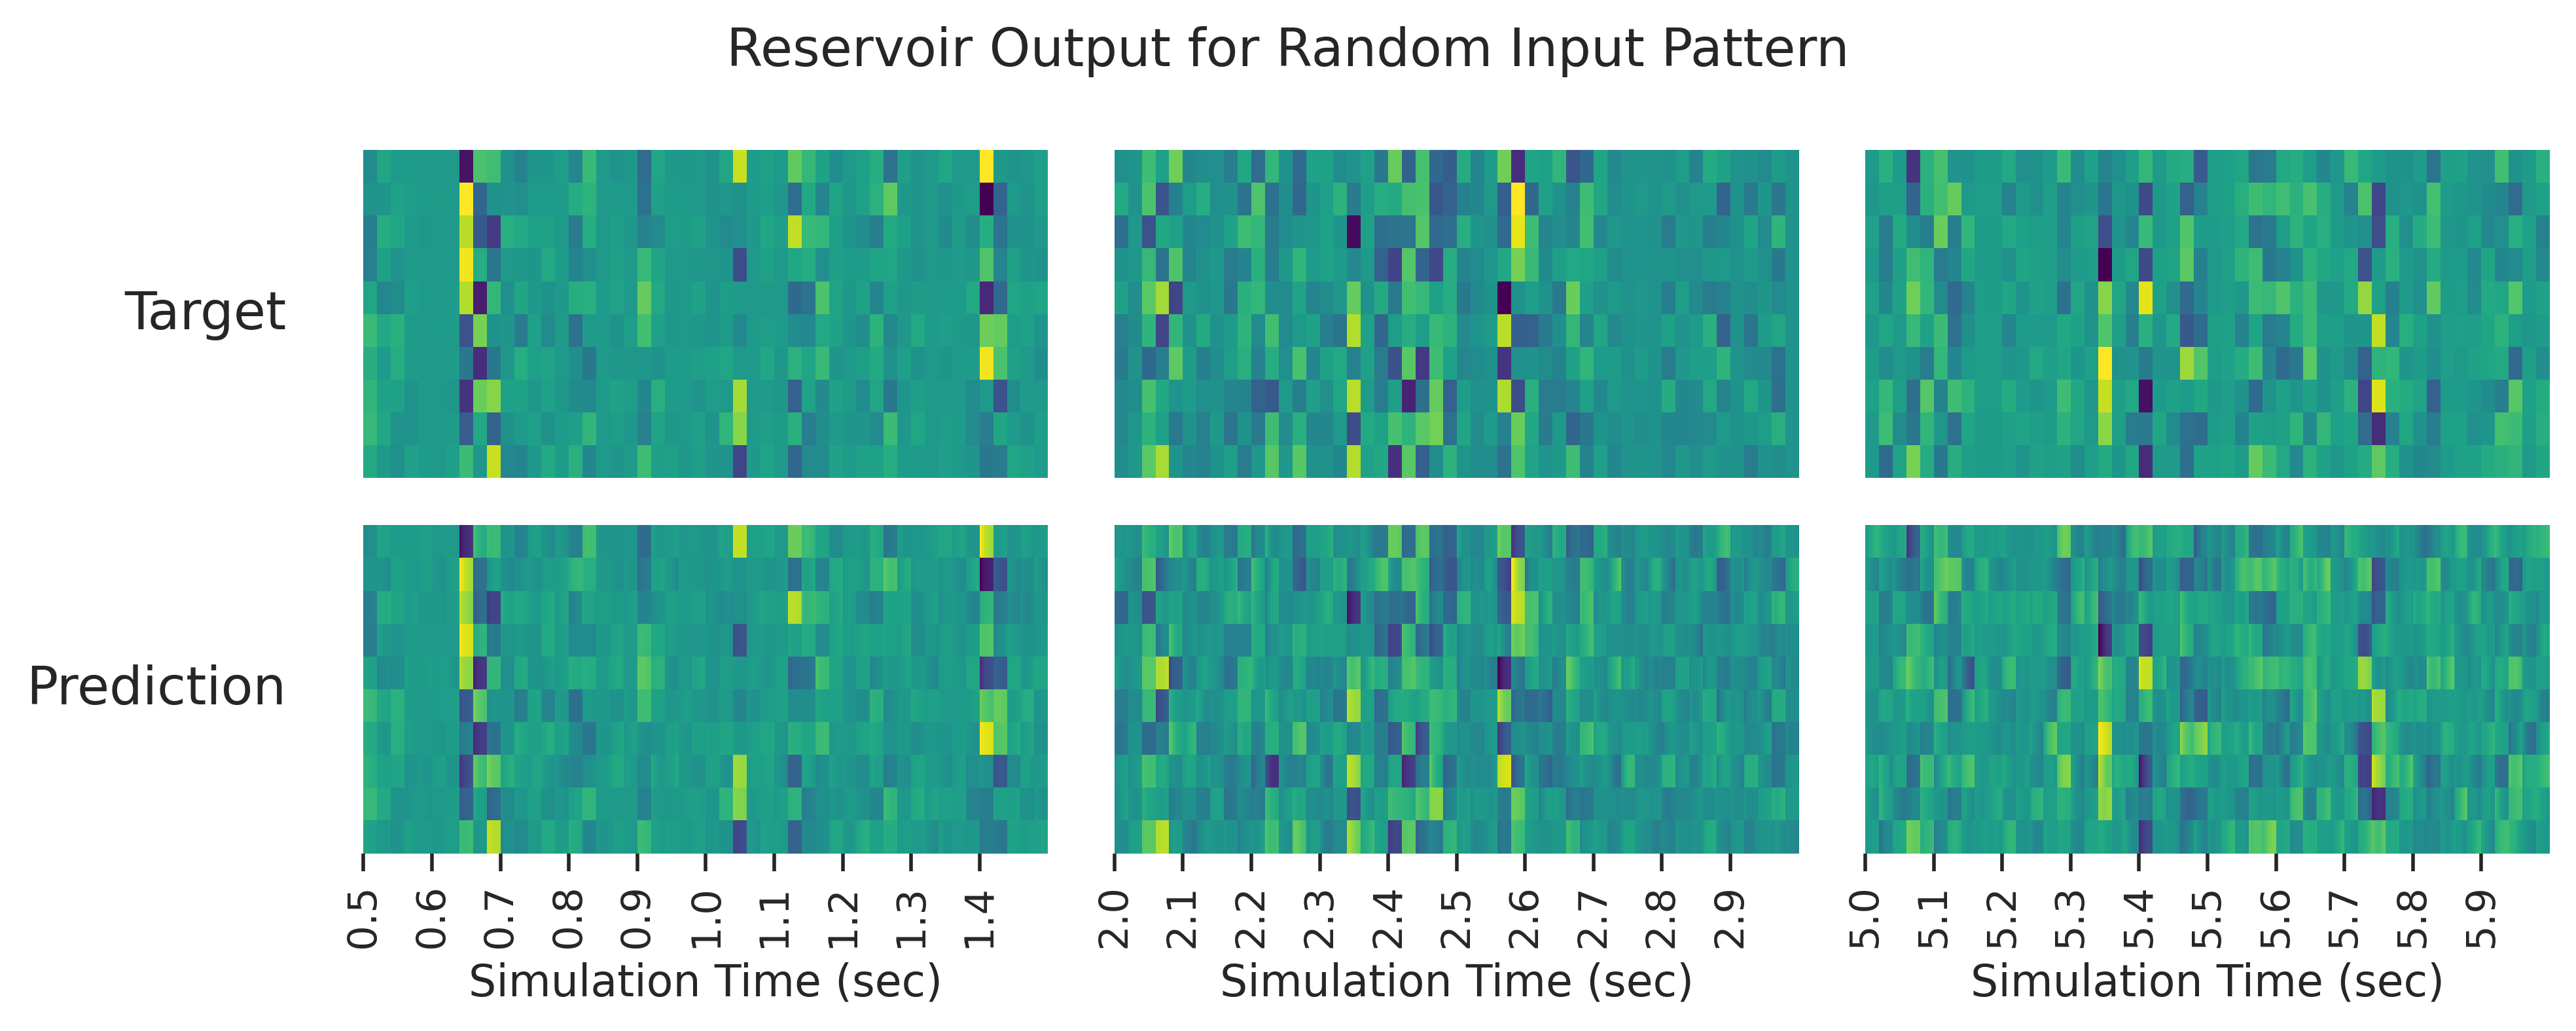

In [106]:
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=400, figsize=(10, 4),
                        subplot_kw={"sharex": True, "sharey": True})

t = jnp.arange(targets.shape[0]) * 1e-3
for i, (tmin, tmax) in enumerate([(500, 1500), (2000, 3000), (5000, 6000)]):
    sns.heatmap(jnp.transpose(targets[tmin:tmax]),
                cbar=False, cmap="viridis", ax=axs[0, i])
    axs[0, i].set_xticklabels([])
    axs[0, i].set_yticklabels([])
    axs[0, i].tick_params(left=False, bottom=False)
    sns.heatmap(jnp.transpose(outputs[tmin:tmax]),
                cbar=False, cmap="viridis", ax=axs[1, i])
    axs[1, i].set_yticklabels([])
    axs[1, i].tick_params(left=False)
    axs[1, i].set_xticks(jnp.arange(0, tmax - tmin, 100),
                    map(lambda x: ("%.1f" % x), t[tmin:tmax:100]))
    axs[1, i].set_xlabel("Simulation Time (sec)")
axs[0, 0].annotate("Target",
                    xy=(0, 0.5),
                    xytext=(-axs[0, 0].yaxis.labelpad - 5, 0),
                    xycoords=axs[0, 0].yaxis.label,
                    textcoords='offset points',
                    size="large",
                    ha='right',
                    va='center')
axs[1, 0].annotate("Prediction",
                    xy=(0, 0.5),
                    xytext=(-axs[1, 0].yaxis.labelpad - 5, 0),
                    xycoords=axs[1, 0].yaxis.label,
                    textcoords='offset points',
                    size="large",
                    ha='right',
                    va='center')
fig.suptitle("Reservoir Output for Random Input Pattern")
fig.tight_layout()
fig.savefig("reservoir-output.pdf")

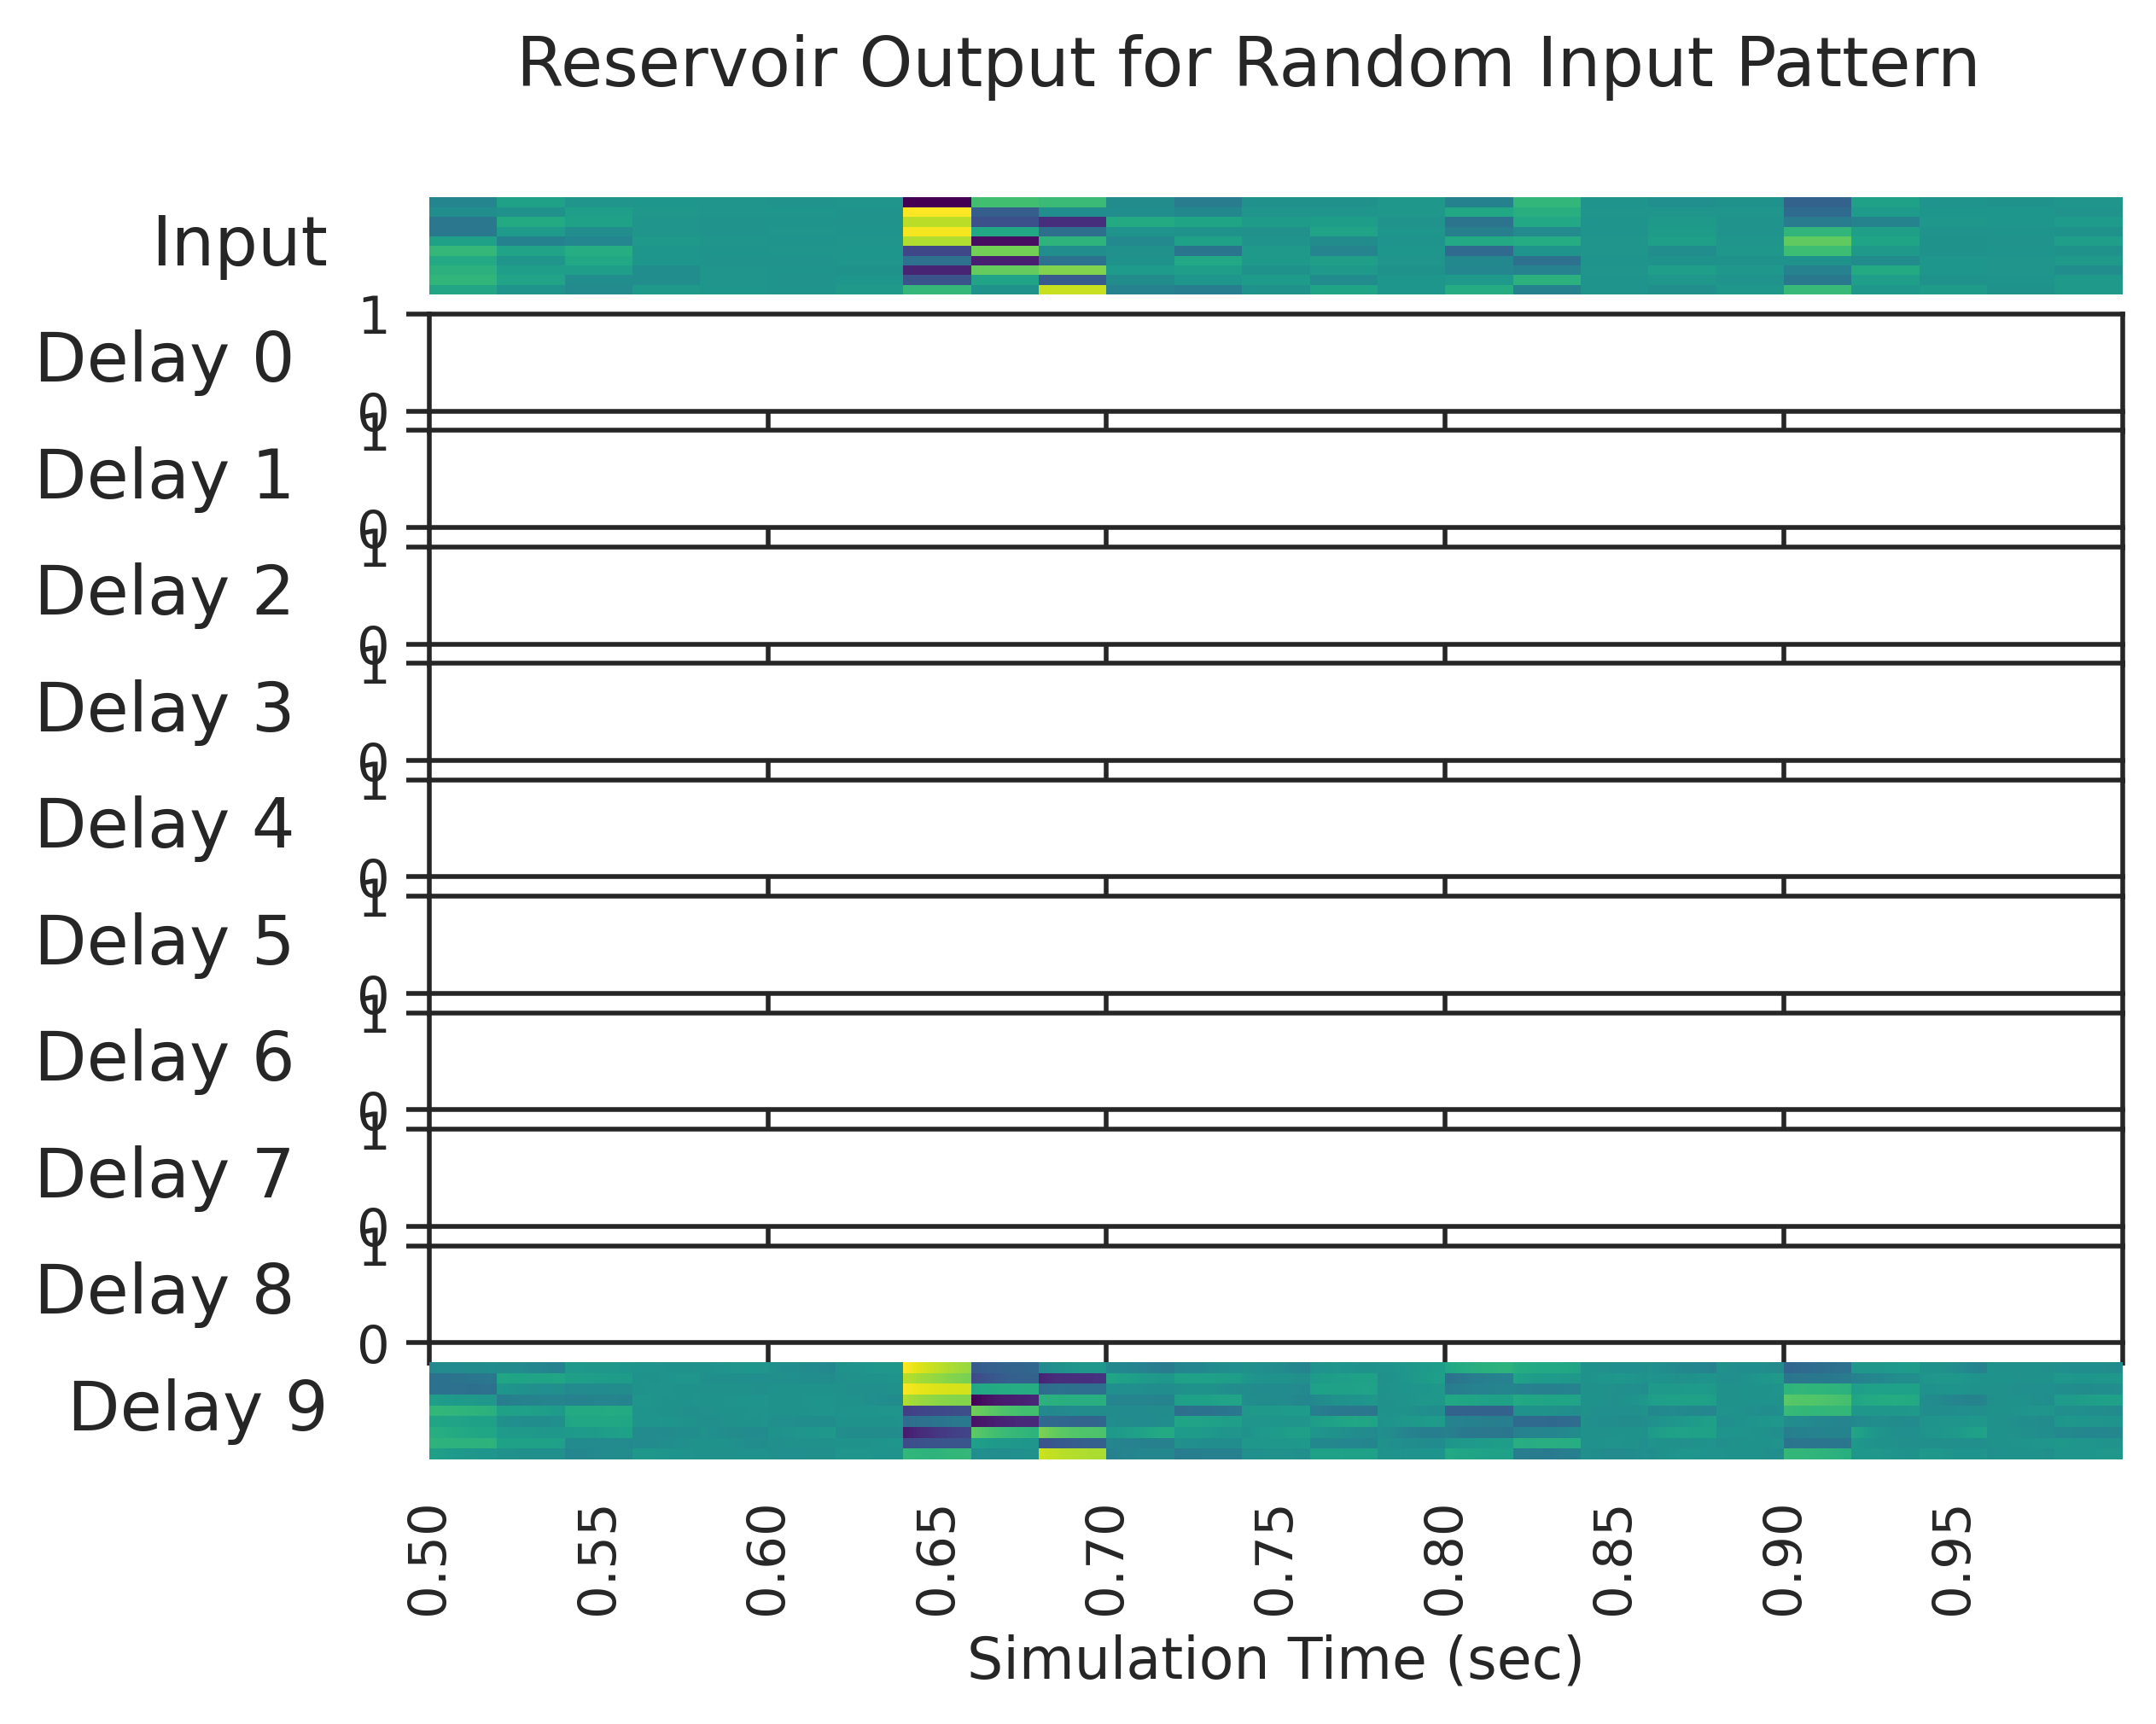

In [89]:
fig, axs = plt.subplots(nrows=11, dpi=400,
                        subplot_kw={"sharex": True, "sharey": True})

d = 50 + 1 + 10
t = jnp.arange(targets.shape[0]) * 1e-3
sns.heatmap(jnp.transpose(targets[500:1000, -d:]),
                cbar=False, cmap="viridis", ax=axs[0])
axs[0].set_yticklabels([])
axs[0].tick_params(left=False, bottom=False)
for i in range(1, targets.shape[1], d):
    ax = axs[10 - i // d]
    sns.heatmap(jnp.transpose(outputs[500:1000, i:(i + d)]),
                cbar=False, cmap="viridis", ax=ax)
    ax.set_yticklabels([])
    ax.tick_params(left=False, bottom=False)
for ax in axs[:-1]:
    ax.set_xticklabels([])
axs[-1].set_xticks(jnp.arange(0, 500, 50),
                   map(lambda x: ("%.2f" % x), t[500:1000:50]))
axs[-1].set_xlabel("Simulation Time (sec)")
for i, ax in enumerate(axs[1:]):
    ax.annotate(f"Delay {i}",
                xy=(0, 0.5),
                xytext=(-ax.yaxis.labelpad - 5, 0),
                xycoords=ax.yaxis.label,
                textcoords='offset points',
                size="large",
                ha='right',
                va='center')
axs[0].annotate("Input",
                xy=(0, 0.5),
                xytext=(-axs[0].yaxis.labelpad - 5, 0),
                xycoords=axs[0].yaxis.label,
                textcoords='offset points',
                size="large",
                ha='right',
                va='center')
fig.suptitle("Reservoir Output for Random Input Pattern")
fig.savefig("resevoir-output.pdf", dpi=400)

# Small experiment results

In [17]:
ckpt_path = "outputs/train-lif-biohsic/linear-results-2/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
linear_ckpt = mgr.restore(mgr.latest_step())

ckpt_path = "outputs/train-lif-biohsic/xor-results-2/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
xor_ckpt = mgr.restore(mgr.latest_step())

In [18]:
linear_data = load_dataset("linear")["train"]
xor_data = load_dataset("xor")["train"]

In [33]:
linear_acc = jnp.stack(linear_ckpt["metrics_history"]["test"]["accuracy"]) * 100
xor_acc = jnp.stack(xor_ckpt["metrics_history"]["test"]["accuracy"]) * 100
linear_hsic = jnp.stack([jnp.stack(linear_ckpt["metrics_history"]["train"][f"hsic_layer{i}"])
                         for i in range(2)], axis=-1)
xor_hsic = jnp.stack([jnp.stack(xor_ckpt["metrics_history"]["train"][f"hsic_layer{i}"])
                      for i in range(3)], axis=-1)

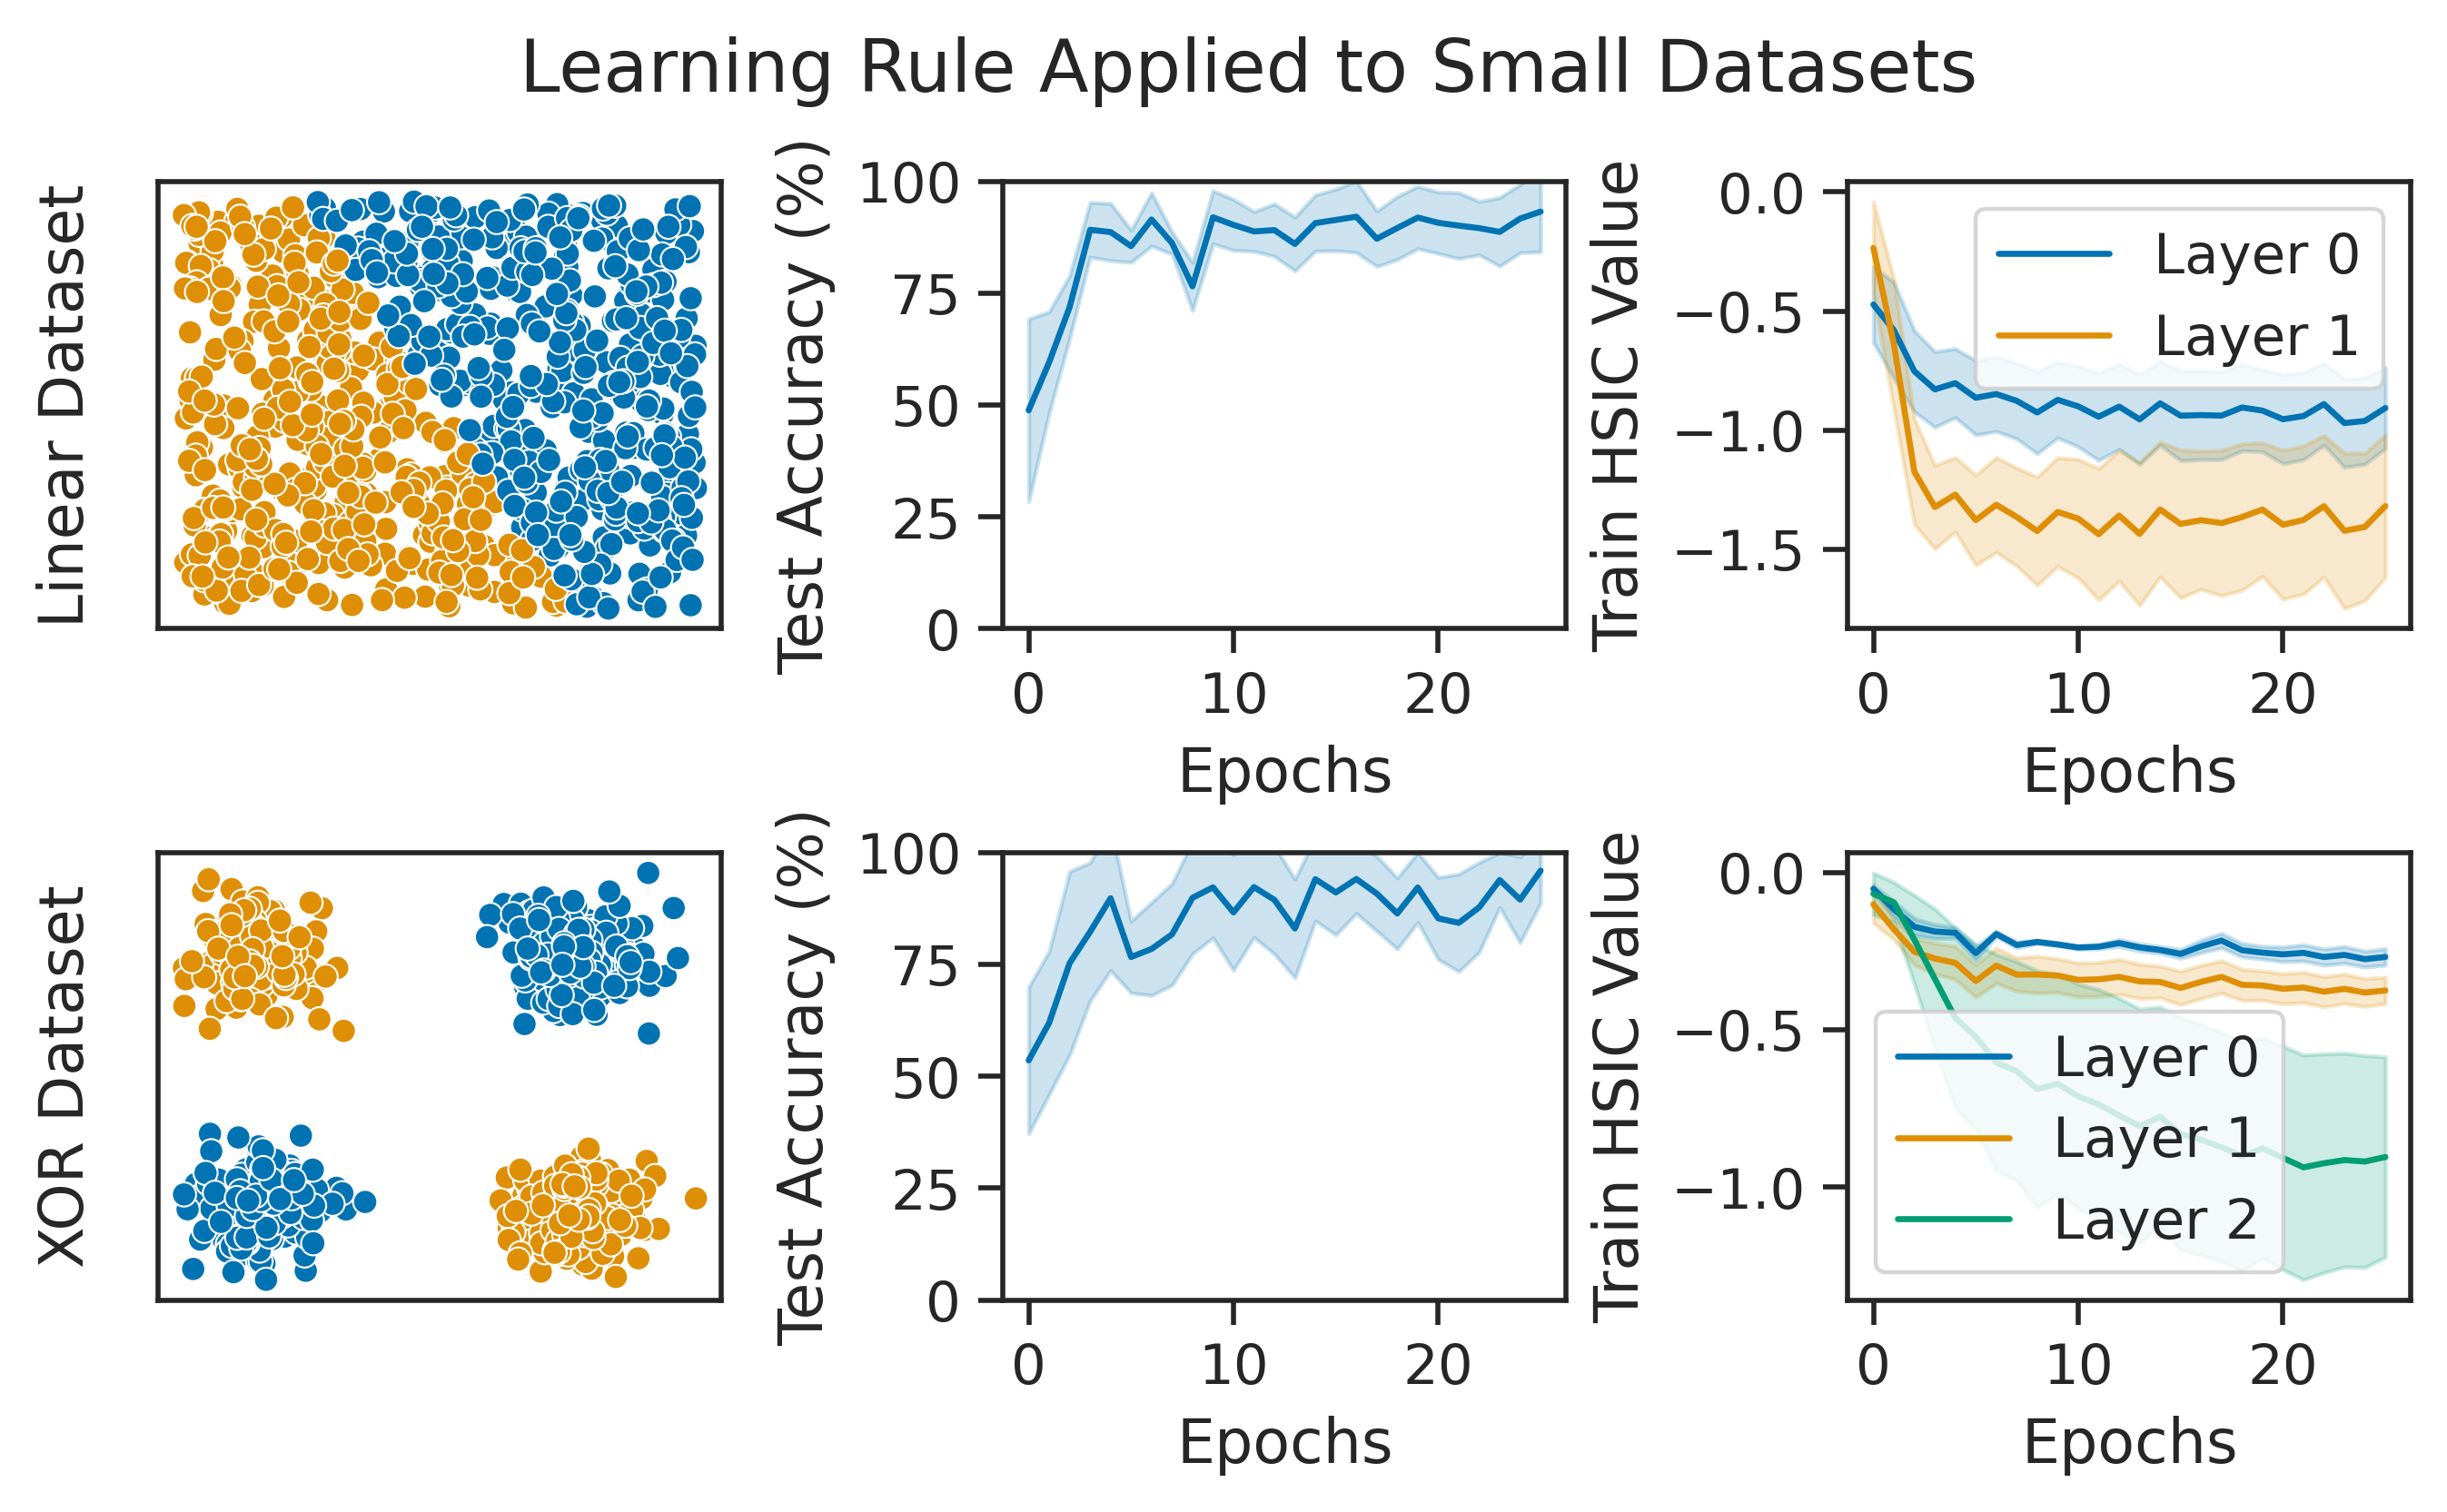

In [47]:
fig, axs = plt.subplots(nrows=2, ncols=3, dpi=400, figsize=(8, 4))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

sns.scatterplot(x=linear_data["input"][:, 0],
                y=linear_data["input"][:, 1],
                hue=linear_data["label"],
                legend=False,
                ax=axs[0, 0])
axs[0, 0].tick_params(left=False, bottom=False)
axs[0, 0].set_xticklabels([])
axs[0, 0].set_yticklabels([])
axs[0, 0].set_ylabel("Linear Dataset")
sns.scatterplot(x=xor_data["input"][:, 0],
                y=xor_data["input"][:, 1],
                hue=xor_data["label"],
                legend=False,
                ax=axs[1, 0])
axs[1, 0].tick_params(left=False, bottom=False)
axs[1, 0].set_xticklabels([])
axs[1, 0].set_yticklabels([])
axs[1, 0].set_ylabel("XOR Dataset")
epochs = jnp.repeat(jnp.arange(linear_acc.shape[0]), linear_acc.shape[1])
sns.lineplot(x=epochs,
             y=jnp.reshape(linear_acc, -1),
             errorbar="sd",
             ax=axs[0, 1])
axs[0, 1].set_xlabel("Epochs")
axs[0, 1].set_ylabel("Test Accuracy (%)")
axs[0, 1].set_ylim(0, 100)
sns.lineplot(x=epochs,
             y=jnp.reshape(xor_acc, -1),
             errorbar="sd",
             ax=axs[1, 1])
axs[1, 1].set_xlabel("Epochs")
axs[1, 1].set_ylabel("Test Accuracy (%)")
axs[1, 1].set_ylim(0, 100)
for i in range(2):
    sns.lineplot(x=epochs,
                 y=jnp.reshape(linear_hsic[:, :, i], -1),
                 errorbar="sd",
                 label=f"Layer {i}",
                 ax=axs[0, 2])
axs[0, 2].set_xlabel("Epochs")
axs[0, 2].set_ylabel("Train HSIC Value")
for i in range(3):
    sns.lineplot(x=epochs,
                 y=jnp.reshape(xor_hsic[:, :, i], -1),
                 errorbar="sd",
                 label=f"Layer {i}",
                 ax=axs[1, 2])
axs[1, 2].set_xlabel("Epochs")
axs[1, 2].set_ylabel("Train HSIC Value")
fig.suptitle("Learning Rule Applied to Small Datasets")
fig.savefig("small-experiment-results.pdf")

# MNIST results

In [2]:
ckpt_path = "outputs/train-bp/mnist-results-2/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
mnist_bp_ckpt = mgr.restore(mgr.latest_step())

ckpt_path = "outputs/train-biohsic/mnist-results/checkpoints/"
mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
mnist_hsic_ckpt = mgr.restore(mgr.latest_step())

# ckpt_path = "outputs/train-bp/cifar10-results/checkpoints/"
# mgr = CheckpointManager(os.sep.join([os.getcwd(), ckpt_path]), PyTreeCheckpointer())
# cifar10_bp_ckpt = mgr.restore(mgr.latest_step())

In [3]:
mnist_bp_acc = jnp.stack(mnist_bp_ckpt["metrics_history"]["test"]["accuracy"]) * 100
mnist_hsic_acc = jnp.stack(mnist_hsic_ckpt["metrics_history"]["test"]["accuracy"]) * 100

Text(0.5, 1.0, 'MNIST Performance')

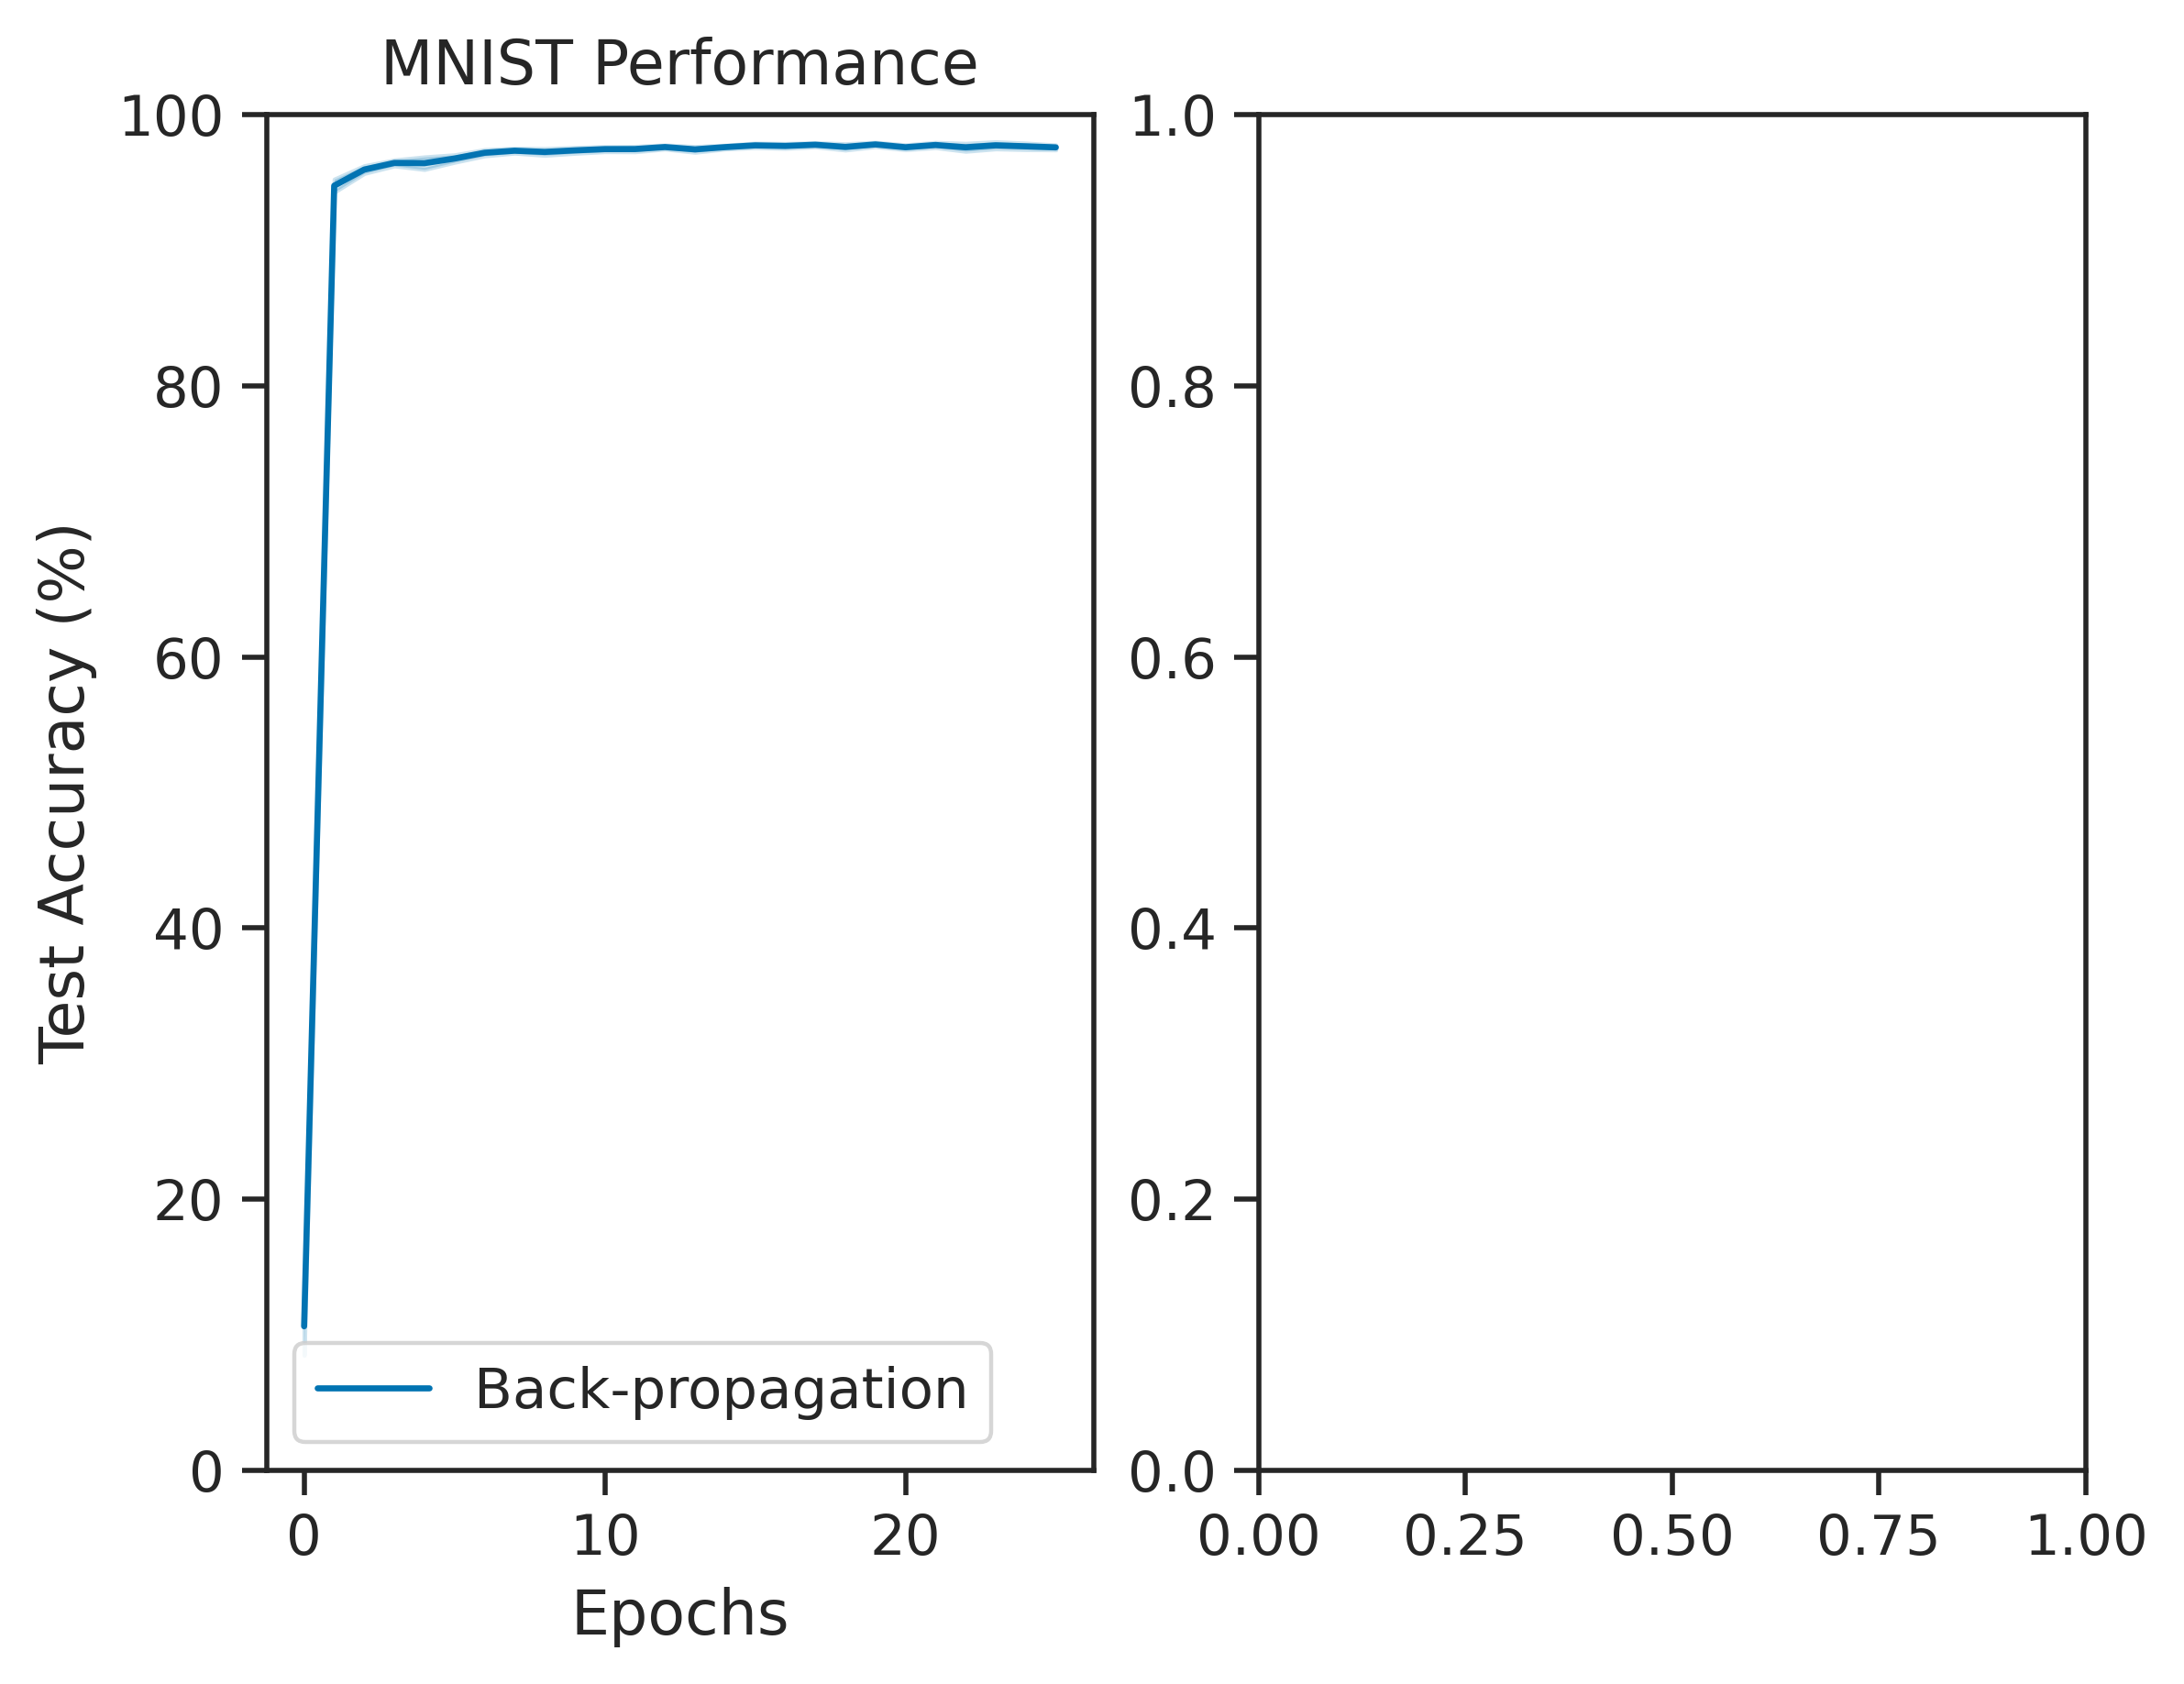

In [4]:
fig, axs = plt.subplots(ncols=2, dpi=400)
# fig.subplots_adjust(hspace=0.5, wspace=0.5)

epochs = jnp.repeat(jnp.arange(mnist_bp_acc.shape[0]), mnist_bp_acc.shape[1])
sns.lineplot(x=epochs,
             y=jnp.reshape(mnist_bp_acc, -1),
             errorbar="sd",
             label="Back-propagation",
             ax=axs[0])
# sns.lineplot(x=epochs,
#              y=jnp.reshape(mnist_hsic_acc, -1),
#              errorbar="sd",
#              label="Our rule",
#              ax=axs[0])
axs[0].set_xlabel("Epochs")
axs[0].set_ylabel("Test Accuracy (%)")
axs[0].set_ylim(0, 100)
axs[0].set_title("MNIST Performance")